# Complete R117 Analysis,

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.gridspec as gridspec
import scipy
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.stats import chisquare
from astropy.time import Time
import scipy.stats as st
import matplotlib.colors as colors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import pandas as pd
import scipy.optimize as spopt
import scipy.integrate as spint
from tqdm import tqdm, trange
from matplotlib.patches import Rectangle
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import chi2

In [9]:
def powerlaw(x, parm):
    k = parm[0]
    return x**(-k)

def powerlaw_wconst(x, parm):
    k = parm[0]
    c = parm[1]
    return c*x**(-k)

def redchisqg(ydata,ymod,dof,sd=None):  
    if sd==None:  
        chisq=np.sum((ydata-ymod)**2)  
    else:  
        chisq=np.sum(((ydata-ymod)/sd)**2 )   
    return chisq/dof

def get_poisson_error(r, conf_level=0.68):
    """
    adapted from Gehrels et al. 1986
    example use:
    rate = np.array([1,2,3,10])
    get_poisson_error(rate, conf_level=0.68) # returns 1-sigma lower and upper limit on the rate
    
    can be used to get the lower and upper limits for burst rate. 
    If bursts_obserrved = 0, it becomes a one sided distrubution, wherein conf_level_onesided = 1 - (1-conf_level)*2 
    """
    low_lim = 0.5 * chi2.ppf((1 - conf_level) / 2, 2 * r)
    low_lim[np.isnan(low_lim)] = 0 
    upp_lim = 0.5 * chi2.ppf((1 + conf_level) / 2, 2 * (r+1))
    upp_lim[np.isnan(upp_lim)] = 0
    
    return low_lim, upp_lim

def log_normal(x, parm):
    mu = parm[0]
    sigma = parm[1]
    constant = parm[2]
    return constant*((1)/(x*sigma*(2*np.pi)**0.5)) * np.exp(-((np.log(x) - mu)**2/(2*sigma**2)))

def normal(x, parm):
    mu = parm[0]
    sigma = parm[1]
    constant = parm[2]
    return constant*((1)/(sigma*(2*np.pi)**0.5)) * np.exp(-0.5*((x - mu)/(sigma))**2)

def double_log_normal(x, parm):
    mu = parm[0]
    sigma = parm[1]
    constant = parm[2]
    mu2 = parm[3]
    sigma2 = parm[4]
    constant2 = parm[5]
    return constant*((1)/(x*sigma*(2*np.pi)**0.5)) * np.exp(-((np.log(x) - mu)**2/(2*sigma**2))) + constant2*((1)/(x*sigma2*(2*np.pi)**0.5)) * np.exp(-((np.log(x) - mu2)**2/(2*sigma2**2)))

def model_int_cf(ecent, ebins, model, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.
       Inputs:
           ecent - energy bin centres, dummy array with length len(ebins)-1 to fool curve_fit into 
                   accepting the function as the correct format for curve_fit.
           ebins - energy bin edges.
           model, parm - the curve_fit model name and input parameter list.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
            
    return counts2, edges2

def plot_spec_model(ebins,cdens,cdens_err,cdens_model, ml_cfpars):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    
    color_list = ['blue', 'orange', 'green', 'red', 'yellow']
    energies = (ebins[1:]+ebins[:-1])/2
    
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,9),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', label='Bin values')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights = cdens_model, density= False, histtype='step', label='Fit')
    ax2.errorbar(energies, cdens-cdens_model, xerr=bwidths/2., yerr=cdens_err, fmt='.', label ='Bin values')
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax2.set_xlabel('Wait time in seconds' , fontsize = 20)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax1.set_ylabel('Normalised events/bin', fontsize = 20)
    ax2.set_ylabel('Data-model', fontsize = 15)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.tick_params(labelsize=14)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax1.legend(prop={'size':15})
    ax1.axvline(x=np.exp(ml_cfpars[0] - ml_cfpars[1]**2), color = 'gray', linestyle='dashed', linewidth = 1)
    ax1.axvline(x=np.exp(ml_cfpars[3] - ml_cfpars[4]**2), color = 'gray', linestyle='dashed', linewidth = 1)
    plt.savefig('Fitthrough300cutoff.pdf')
    
    return energies, (np.abs(cdens/cdens_model-1)/(cdens_err/cdens_model))
    
def plot_fit(model, p0, var_dict, counts2, edges2, bwidths, cdens, cdens_err, energies, plot):
    """ calculates and prints the MLEs for the parameters, 
        plots the fit as a histogram through the binned data,
        calculates and prints the minimum chi^2 and the goodness of fit
    :param model: the curve_fit model name
    :param p0: the initial guesses for the parameters
    :param var_dict: a dictionary of the variable names of the parameters
    :param counts2: the rebinned count array
    :param edges2: the rebinned edge array
    :param bwidths: bin width
    :param cdens: count density array of each bin
    :param cdens_err: count density error array of each bin
    :param energies: energy value array of the points
    :return: the values and their positions with larger deviations from the model than 2 sigma
    """
    
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                            energies, cdens, p0, sigma=cdens_err)

    #use the covariance matrix to find the errors
    err = np.sqrt(np.diag(ml_cfcovar)) 

    best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
    
    #plots the model and returns the energy of each point and its error bar
    if plot:
        energies_of_points, error_bar_from_model = plot_spec_model(edges2,cdens,cdens_err,best_model, ml_cfpars)
    
#     #prints the found MLEs
#     for i in range(len(p0)):
#         print("Variable {} = ".format(var_dict[i]) + str(ml_cfpars[i]) + " +/- " + str(err[i]))
    
    minchisq = np.sum(((cdens-model(energies,ml_cfpars))/cdens_err)**2)
    dof = len(energies)-len(p0)
    
    return ml_cfpars, best_model, err, minchisq, edges2,cdens,cdens_err,best_model, energies_of_points

def fit_gaussian_to_dataset(dataset, bins, plot=True):
    """ plots the data into rebinned bins
        fits and plots a straight power-law model to the rebinned data
        fits and plots a straight power-law model plus a gaussian line feature to the rebinned data
    :param dataset: the input data to be rebinned and fitted 
    :param location: a guess of the location of the gaussian line feature
    :return ml_cfpars: the MLEs of the parameters
    :return err: the errors on the MLE of the parameters
    :return minchisq_pl: the minimum chi-squared for the single power-law model
    :return minchisq_pl_gaus: the minimum chi-squared for the power-law + gaussian model
    """ 
    hist, bins, = np.histogram(dataset, bins=bins, density=False)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    counts, edges = np.histogram(dataset, bins=logbins, density=False)
    
    #rebin the data into different bins and counts
    mincounts = 2
    counts2, edges2 = histrebin(mincounts,counts,edges)
    energies = (edges2[:-1]+edges2[1:])/2.
    
    bwidths = np.diff(np.log(edges2)) 
    cdens = counts2/bwidths 
    cdens_err = np.sqrt(counts2)/bwidths 

    #fit the continuum power-law model plus the gaussian to the data
#     ml_cfpars, best_model, err, minchisq_pl,ebins,cdens,cdens_err,cdens_model = plot_fit(log_normal, [5, 1.4, 25000], {0:'Noise Offset', 1:'N0', 2:'Lambda'}, counts2, edges2, bwidths, cdens, cdens_err, energies, plot)    
    ml_cfpars, best_model, err, minchisq_pl,ebins,cdens,cdens_err,cdens_model, energies_of_points = plot_fit(double_log_normal, [5, 1.4, 25000, 0.001, 1.2, 1000], {0:'Noise Offset', 1:'N0', 2:'Lambda'}, counts2, edges2, bwidths, cdens, cdens_err, energies, plot)    

    return np.exp(ml_cfpars[0] - ml_cfpars[1]**2), np.exp(ml_cfpars[3] - ml_cfpars[4]**2), energies_of_points, cdens, cdens_err

def kde_applied(input_data_array):
    hist1, bins1 = np.histogram(input_data_array, bins=40)
    logbins1 = np.logspace(np.log10(bins1[0]),np.log10(np.ceil(bins1[-1])),len(bins1))

    hist1, bins= np.histogram(input_data_array, bins = logbins1)
    xdata = np.log10(((bins+np.roll(bins, 1))/2)[1:])
    ydata = hist1

    x_test = xdata[:, np.newaxis]
    x_train = np.log10(input_data_array)[:, np.newaxis]

    bandwidth = np.linspace(0,0.2,50)
    kde = KernelDensity(kernel='gaussian')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(x_train)
    kde = grid.best_estimator_
    log_dens = kde.score_samples(x_test)

    total_value = 1e15
    factor_increase = np.linspace(0,100, 2000)

    for i in range(len(factor_increase)):
        total = sum(np.abs((ydata)-factor_increase[i]*np.exp(log_dens)))
        if total < total_value:
            total_value  =total
            best_fit_factor = factor_increase[i]

    return xdata,ydata,x_test,best_fit_factor*np.exp(log_dens)

### Acquiring the data

In [10]:
burst_csv = pd.read_csv('Complete_Parameters.csv')

for i in range(len(burst_csv)):
    if np.isnan(burst_csv['Real Burst'][i]):
        burst_csv['Real Burst'][i] = False
        
display(burst_csv) 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (13,14,15,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-10-e2726dafa70f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burst_csv['Real Burst'][i] = False


,Unnamed: 0,Unnamed: 0.1,lilo name,cand name,power top,power middle,power bottom,power factor,time width,freq width,...,model B Probability,model C Probability,model D Probability,model E Probability,model F Probability,model G Probability,model H Probability,FETCH prediction,bowtie prediction,Real Burst
0,0.0,0.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_0.12060...,0.090515,0.271799,0.315393,0.861779,2784.0,4.0,...,1.141243e-01,0.000566,9.953222e-05,1.108346e-05,5.953738e-07,8.332111e-08,2.542536e-09,False,False,False
1,1.0,1.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_2.67578...,0.225863,0.168229,0.147636,0.744826,2640.0,3.0,...,6.431119e-08,0.016453,5.933465e-05,1.017336e-10,4.997588e-15,1.385601e-14,3.567449e-15,False,False,False
2,2.0,2.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_4.31834...,0.021031,0.018754,0.009961,0.891732,1376.0,3.0,...,2.633538e-04,0.000004,4.902102e-06,1.576683e-05,1.157269e-07,1.923298e-07,7.827413e-08,False,False,False
3,3.0,3.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_10.1164...,0.033300,0.036183,0.032494,1.086576,2352.0,3.0,...,1.899140e-03,0.000017,8.816750e-07,1.702615e-08,7.864714e-06,1.522370e-07,3.297041e-05,False,False,False
4,4.0,4.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_16.0321...,0.178091,0.174038,0.102811,0.977245,112.0,2.0,...,4.990985e-06,0.000179,9.097985e-07,4.326726e-07,8.882903e-10,3.957524e-05,9.464552e-10,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34603,33473.5,NaN,lilo_2x3_8bit,./cand_tstart_59870.876897277783_tcand_30.1810...,NaN,NaN,NaN,NaN,983.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34604,33675.5,NaN,lilo_1x1_8bit,./cand_tstart_59869.877662037034_tcand_38.6381...,NaN,NaN,NaN,NaN,1084.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34605,33883.5,NaN,lilo_1x4_8bit,./cand_tstart_59869.881828703699_tcand_38.4213...,NaN,NaN,NaN,NaN,1211.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34606,34422.5,NaN,lilo_1x1_8bit,./cand_tstart_59867.901782407411_tcand_17.1152...,NaN,NaN,NaN,NaN,225.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True


## FETCH underperforms

In [11]:
FETCH_misclass = burst_csv[burst_csv['FETCH prediction'] == False][np.array([burst_csv[burst_csv['FETCH prediction'] == False]['Real Burst']], dtype=bool).T][:-62]

display(FETCH_misclass)

,Unnamed: 0,Unnamed: 0.1,lilo name,cand name,power top,power middle,power bottom,power factor,time width,freq width,...,model B Probability,model C Probability,model D Probability,model E Probability,model F Probability,model G Probability,model H Probability,FETCH prediction,bowtie prediction,Real Burst
1522,1522.0,1522.0,lilo_4x4_8bit,./cand_tstart_60047.411675629628_tcand_30.2788...,0.027568,0.039746,0.019941,1.441758,789.0,40.0,...,0.000074,3.298866e-07,0.000002,8.546619e-07,1.201415e-06,5.821213e-08,3.803450e-08,False,True,True
1652,1652.0,1652.0,lilo_1x3_8bit,./cand_tstart_60044.397696759261_tcand_27.5043...,0.016779,0.112821,0.021602,5.222847,816.0,60.0,...,0.285681,1.018301e-05,0.000136,3.474128e-06,2.225561e-05,3.930568e-07,2.703162e-09,False,True,True
2303,2303.0,2303.0,lilo_3x2_8bit,./cand_tstart_60040.420264462955_tcand_33.6479...,0.019834,0.029749,0.011370,1.499893,1412.0,87.0,...,0.000028,1.301889e-05,0.000140,4.690387e-06,1.896890e-06,5.731783e-07,1.661218e-08,False,True,True
2399,2399.0,2399.0,lilo_3x5_8bit,./cand_tstart_60040.424431129628_tcand_81.8246...,0.023295,0.038165,0.020034,1.638329,160.0,14.0,...,0.004759,2.821577e-06,0.000079,4.772638e-10,1.783703e-11,9.148656e-09,6.981093e-10,False,True,True
2688,2688.0,2688.0,lilo_2x1_8bit,./cand_tstart_60030.427360240741_tcand_0.73715...,0.011272,0.026058,0.014908,1.747883,184.0,25.0,...,0.000004,7.909059e-05,0.000429,7.216080e-06,7.628152e-07,2.427019e-06,5.404236e-08,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33596,33596.0,33596.0,lilo_3x4_8bit,./cand_tstart_59870.886051499998_tcand_36.9639...,0.020230,0.073633,0.035876,2.052419,288.0,80.0,...,0.001040,1.482856e-04,0.000084,1.603493e-07,2.264476e-10,9.568235e-09,3.994112e-05,False,True,True
33628,33628.0,33628.0,lilo_3x6_8bit,./cand_tstart_59870.888829277777_tcand_59.0540...,0.016291,0.040735,0.018351,2.219799,1040.0,43.0,...,0.006073,7.179782e-06,0.000004,2.408416e-05,2.862005e-09,5.876053e-08,5.474055e-08,False,True,True
33809,33809.0,33809.0,lilo_1x2_8bit,./cand_tstart_59869.879050925920_tcand_91.6333...,0.007042,0.015801,0.005174,2.243693,152.0,12.0,...,0.000008,3.266477e-05,0.002215,1.391633e-06,1.039175e-06,4.170759e-06,6.785881e-08,False,True,True
34143,34143.0,34143.0,lilo_2x2_8bit,./cand_tstart_59869.886816259255_tcand_1.36640...,0.028852,0.038668,0.018726,1.340198,112.0,18.0,...,0.000014,6.171553e-06,0.000113,4.929489e-05,5.948449e-04,8.681648e-05,4.291711e-03,False,True,True


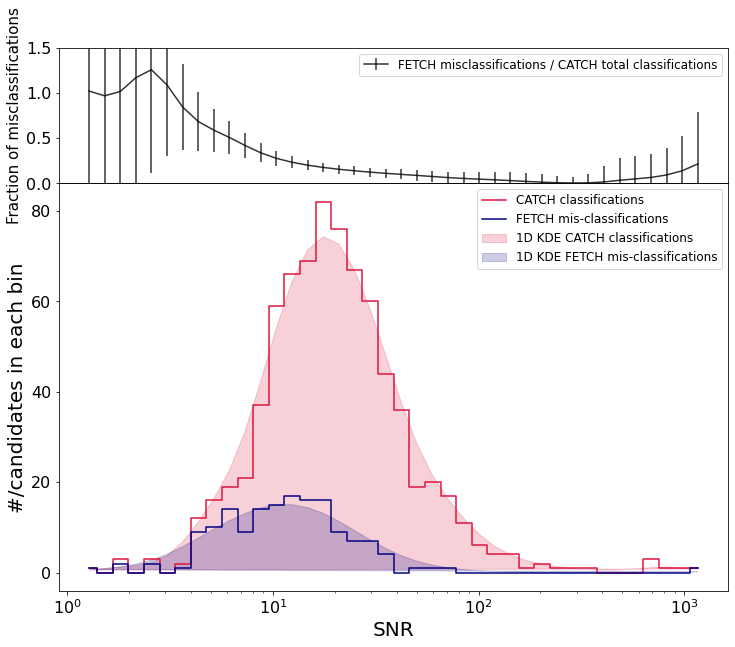

In [12]:
xdata_catch, ydata_catch, x_kde_catch, y_kde_catch = kde_applied(np.array(burst_csv[burst_csv['Real Burst'] == True]['S/N']))
xdata_fetch, ydata_fetch, x_kde_fetch, y_kde_fetch = kde_applied(np.array(FETCH_misclass['S/N']))

fig = plt.figure(figsize=(12, 10))
rows=2
cols=1
widths = [1]
heights = [1,3]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1,0])

ax.fill(10**x_kde_catch, y_kde_catch, c='crimson', alpha = 0.2, label = '1D KDE CATCH classifications')   
ax.plot(10**xdata_catch, ydata_catch, drawstyle='steps-mid', color='crimson', label = 'CATCH classifications')
ax.fill(10**x_kde_fetch, y_kde_fetch, c='navy', alpha = 0.2, label = '1D KDE FETCH mis-classifications')   
ax.plot(10**xdata_fetch, ydata_fetch, drawstyle='steps-mid', color='navy', label = 'FETCH mis-classifications')   

yerr = (y_kde_fetch/y_kde_catch) * ((np.sqrt(y_kde_fetch)/y_kde_fetch)**2+(np.sqrt(y_kde_catch)/y_kde_catch)**2)**0.5

ax2 = fig.add_subplot(gs[0,0])
ax2.errorbar(10**x_kde_catch, y_kde_fetch/y_kde_catch, yerr = yerr ,alpha = 0.8, c='k', label='FETCH misclassifications / CATCH total classifications')
ax2.set_ylabel('Fraction of misclassifications', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xscale('log')
ax2.get_xaxis().set_visible(False)
ax2.set_ylim(0,1.5)
ax2.legend(prop={'size' : 12})

ax.set_xlabel('SNR', fontsize = 20)
ax.set_ylabel('#/candidates in each bin', fontsize = 20)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(prop={'size' : 12})
plt.savefig('FETCH misclassifications based on SNR.pdf')
plt.show()

In [13]:
extra_bursts = np.array(burst_csv[-62:])

fetch_identifies_doubleburst_correctly = 0
total = 0
for i in range(len(extra_bursts)):
#     print(int(extra_bursts[i][0]))
#     print(np.array(burst_csv[burst_csv['Unnamed: 0'] == int(extra_bursts[i][0])]['FETCH prediction'])[0])
    if np.array(burst_csv[burst_csv['Unnamed: 0'] == int(extra_bursts[i][0])]['FETCH prediction'])[0]:
        fetch_identifies_doubleburst_correctly += 1
    total += 1
    
print("Total multiple bursts: ", total)
print("Total multiple bursts FETCH identifies as containing an FRB: ", fetch_identifies_doubleburst_correctly)

Total multiple bursts:  62
Total multiple bursts FETCH identifies as containing an FRB:  52


## R117 properties

### Temporal and Frequency widths

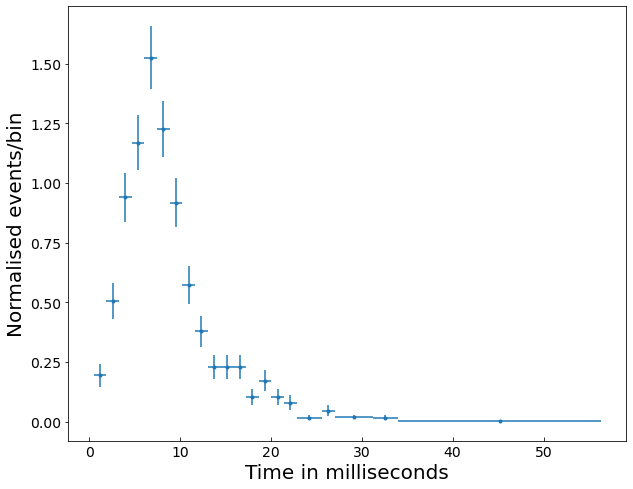

In [14]:
nbins = 40
counts, edges = np.histogram(np.array(burst_csv[burst_csv['Real Burst'] == True]['time width']), bins=nbins, density=False)

#rebin the data into different bins and counts
mincounts = 3
counts2, edges2 = histrebin(mincounts,counts,edges)

bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

color_list = ['blue', 'orange', 'green', 'red', 'yellow']

fig = plt.figure(figsize=(10,8))
energies = (edges2[1:]+edges2[:-1])/2
bwidths = np.diff(edges2)
plt.errorbar(energies*1.6e-2, cdens, xerr=bwidths/2.*1.6e-2, yerr=cdens_err, fmt='.', label='Bin values')
plt.tick_params(labelsize=14)
plt.tick_params(axis="x",direction="in",which="both", length=4)
plt.ylabel('Normalised events/bin', fontsize = 20)
# plt.title('Distribution of the time-domain burstwidth', fontsize = 20)
plt.xlabel('Time in milliseconds', fontsize = 20)
plt.savefig('Time_width.pdf')
plt.show()

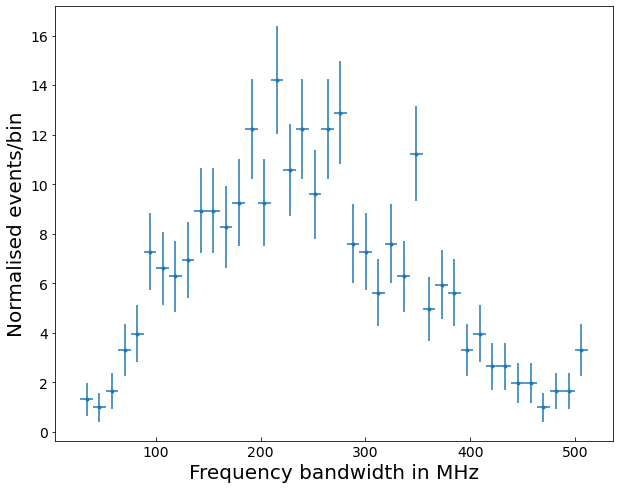

In [15]:
nbins = 40
counts, edges = np.histogram(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width']), bins=nbins, density=False)

#rebin the data into different bins and counts
mincounts = 3
counts2, edges2 = histrebin(mincounts,counts,edges)

bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

color_list = ['blue', 'orange', 'green', 'red', 'yellow']

fig = plt.figure(figsize=(10,8))
energies = (edges2[1:]+edges2[:-1])/2
bwidths = np.diff(edges2)
# plt.axvline(x=4*np.mean(np.array(burst_csv[burst_csv['truth'] == True]['freq width'])),color='k',linewidth=2, linestyle='--')
plt.errorbar(4*energies, cdens, xerr=bwidths/2.*4, yerr=cdens_err, fmt='.', label='Bin values')
plt.tick_params(labelsize=14)
plt.tick_params(axis="x",direction="in",which="both", length=4)
plt.ylabel('Normalised events/bin', fontsize = 20)
# plt.title('Distribution of the Freq-domain burstwidth', fontsize = 20)
plt.xlabel('Frequency bandwidth in MHz', fontsize = 20)
plt.savefig('Freq_width.pdf')
plt.show()

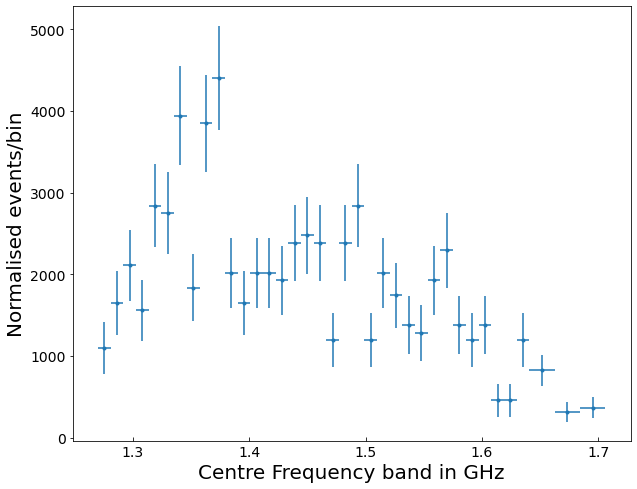

In [16]:
nbins = 40
counts, edges = np.histogram(np.array(burst_csv[burst_csv['Real Burst'] == True]['center frequency']), bins=nbins, density=False)

#rebin the data into different bins and counts
mincounts = 4
counts2, edges2 = histrebin(mincounts,counts,edges)

bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

color_list = ['blue', 'orange', 'green', 'red', 'yellow']

fig = plt.figure(figsize=(10,8))
energies = (edges2[1:]+edges2[:-1])/2
bwidths = np.diff(edges2)
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', label='Bin values')
plt.tick_params(labelsize=14)
plt.tick_params(axis="x",direction="in",which="both", length=4)
plt.ylabel('Normalised events/bin', fontsize = 20)
# plt.title('Distribution of the Freq-domain burstwidth', fontsize = 20)
plt.xlabel('Centre Frequency band in GHz', fontsize = 20)
plt.savefig('Centrefrequency.pdf')
plt.show()

In [17]:
frb_time = []
frb_freqcentre = []
frb_freqwidth = []
for i in range(len(burst_csv[burst_csv['Real Burst'] == True])):
    frb_time.append(float(np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[2]))
    frb_freqcentre.append(1000*float(np.array(burst_csv[burst_csv['Real Burst'] == True]['center frequency'])[i]))
    frb_freqwidth.append(4*float(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])[i]))

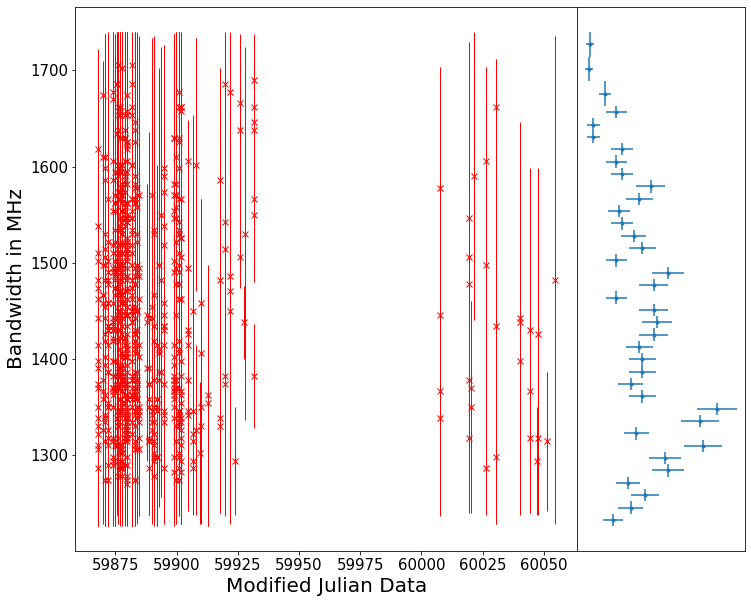

In [18]:
fig = plt.figure(figsize=(12, 10))
rows=1
cols=2
widths = [3,1]
heights = [1]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)
ax1 = fig.add_subplot(gs[0,0])
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.errorbar(frb_time, frb_freqcentre, np.array(frb_freqwidth)/2 ,linewidth = 1, fmt='x', color='r')
ax1.set_xlabel('Modified Julian Data', fontsize = 20)
ax1.set_ylabel('Bandwidth in MHz', fontsize = 20)

ax2 = fig.add_subplot(gs[0,1])
ax2.errorbar(cdens, energies, yerr=bwidths/2., xerr=cdens_err, fmt='.', label='Bin values')
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel('Normalised events/bin', fontsize = 20)
ax2.set_xlabel('Centre Frequency band in GHz', fontsize = 20)
plt.savefig('Bandwidth_all_mjds.pdf')
plt.show()

### Wait Times

In [19]:
cand_ar = []
cand_full_ar = []
time_burst = []

for i in trange(len(burst_csv[burst_csv['Real Burst'] == True])):
    cand = np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[2][:5]
    canf_full = np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[2]
    time_burst.append(np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[-5])
    cand_full_ar.append(canf_full)
    cand_ar.append(cand)
    
cand_ordered_full_ar = [[] for _ in range(len(np.unique(cand_ar)))]
time_burst_full = [[] for _ in range(len(np.unique(cand_ar)))]

for i in range(len(cand_ar)):
    for j in range(len(np.unique(cand_ar))):
        if np.unique(cand_ar)[j] == cand_ar[i]:
            cand_ordered_full_ar[j].append(cand_full_ar[i])
            time_burst_full[j].append(time_burst[i])

100%|███████████████████████████████████████████████████████████████████████████████| 766/766 [00:06<00:00, 122.38it/s]


In [20]:
full_time_in_seconds_for_each_candidate = [[] for _ in range(len(np.unique(cand_ar)))]
for j in range(len(np.unique(cand_ar))):
    seconds_array = []
    first_burst = np.array(np.sort(cand_ordered_full_ar[j]).astype(float))[0]
    for i in range(len(cand_ordered_full_ar[j])):
        time_between = Time(np.array(cand_ordered_full_ar[j]).astype(float)[i] - first_burst, format='mjd').isot
        seconds_between = float(time_between.split(':')[-2])*60 + float(time_between.split(':')[-1]) + float(time_burst_full[j][i])
        full_time_in_seconds_for_each_candidate[j].append(seconds_between)

In [21]:
wait_time = []
wait_time_59877 = []
for i in range(len(np.unique(cand_ar))):
    if np.unique(cand_ar)[i] == '59877':
        wait_time_59877 = np.concatenate((wait_time_59877, np.array(sorted(full_time_in_seconds_for_each_candidate[i])-
               np.roll(sorted(full_time_in_seconds_for_each_candidate[i]), 1))[1:]))
    wait_time = np.concatenate((wait_time, np.array(sorted(full_time_in_seconds_for_each_candidate[i])-
               np.roll(sorted(full_time_in_seconds_for_each_candidate[i]), 1))[1:]))

In [22]:
wait_time=np.delete(wait_time,np.argwhere(wait_time == 0))

In [23]:
def Ppoisson(x, parm):
    R = parm[0]
    return (1 - np.exp(-x * R))

def PWeibull(x, parm):
    Rw = parm[0]
    k = parm[1]
    return (1 - np.exp(-(x * Rw * math.gamma(1+1/k))**k))
    
def plot_spec_model(ebins,cdens,cdens_err,cdens_model, ml_cfpars):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    
    color_list = ['blue', 'orange', 'green', 'red', 'yellow']
    energies = (ebins[1:]+ebins[:-1])/2
    
    bwidths = np.diff(ebins)
    
    fig = plt.figure(figsize=(16, 12))
    rows=3
    cols=1
    widths = [1]
    heights = [1,3,1]

    gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

    ax1 = fig.add_subplot(gs[1,0])
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', label='Bin values', c = 'navy', alpha = 0.7)
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, color='crimson', weights = cdens_model, density= False, histtype='step', label='Fit')
    ax2 = fig.add_subplot(gs[2,0])
    ax2.errorbar(energies, cdens-cdens_model, xerr=bwidths/2., yerr=cdens_err, fmt='.', label ='Bin values', c = 'navy', alpha = 0.7)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax2.set_xlabel('Wait time in seconds' , fontsize = 20)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax1.set_ylabel('Normalised events/bin', fontsize = 20)
    ax2.set_ylabel('Data-model', fontsize = 15)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.tick_params(labelsize=14)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax1.legend(prop={'size':15})
    ax1.axvline(x=np.exp(ml_cfpars[0] - ml_cfpars[1]**2), color = 'gray', linestyle='dashed', linewidth = 1)
    ax1.axvline(x=np.exp(ml_cfpars[3] - ml_cfpars[4]**2), color = 'gray', linestyle='dashed', linewidth = 1)
    ax1.text(1.1*np.exp(ml_cfpars[0] - ml_cfpars[1]**2), 70, str(np.round(np.exp(ml_cfpars[0] - ml_cfpars[1]**2),2))+' s', rotation='vertical', color = 'gray', alpha = 0.75)
    ax1.text(1.1*np.exp(ml_cfpars[3] - ml_cfpars[4]**2), 70, str(np.round(np.exp(ml_cfpars[3] - ml_cfpars[4]**2)*1000, 2))+' ms', rotation='vertical', color = 'gray', alpha = 0.75)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    
    if ebins[0] == 9.999999997489796e-5:
        cdens = cdens[13:]
        energies = energies[13:]

    p0 = [0.011]
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, energies, Ppoisson, *parm), energies, np.cumsum(cdens)/max(np.cumsum(cdens)), p0)
    dof = len(energies)-len(p0)
    
    p1 = [0.011, 1]
    ml_cfpars1, ml_cfcovar1 = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, energies, PWeibull, *parm), energies, np.cumsum(cdens)/max(np.cumsum(cdens)), p1)
    dof1 = len(energies)-len(p1)
        
    ax3 = fig.add_subplot(gs[0,0], sharex=ax1)
    ax3.scatter(energies, np.cumsum(cdens)/max(np.cumsum(cdens)),label='CDF wait times', c = 'navy', alpha = 0.7, marker = 'x')
    ax3.plot(energies, Ppoisson(energies, ml_cfpars),label='Poisson rate {} ± {} bursts/hr'.format(np.round(ml_cfpars[0]*3600,1), np.round(np.sqrt(np.diag(ml_cfcovar))[0]*3600,1)), c = 'crimson', alpha = 0.7)
    ax3.plot(energies, PWeibull(energies, ml_cfpars1), label='Weibull rate {} ± {} bursts/hr, k = {} ± {}'.format(np.round(ml_cfpars1[0]*3600,1), np.round(np.sqrt(np.diag(ml_cfcovar1))[0]*3600,1), np.round(ml_cfpars1[1],1), np.round(np.sqrt(np.diag(ml_cfcovar1))[1],1)), c = 'orange', alpha = 0.7)
    ax3.set_xscale('log')
    ax3.legend(prop={'size':15})
    ax3.set_yticks([0.0, 0.5, 1.0])
    ax3.tick_params(axis='both', which='major', labelsize=20)
    ax3.set_ylabel('Cumulative Density', fontsize = 15)
    ax1.yaxis.set_label_coords(-0.06,0.5)
    ax2.yaxis.set_label_coords(-0.06,0.5)
    ax3.yaxis.set_label_coords(-0.06,0.5)
    ax3.get_xaxis().set_visible(False)
    plt.savefig('Waittimes_with_cdf.pdf')
    return energies, ml_cfcovar1

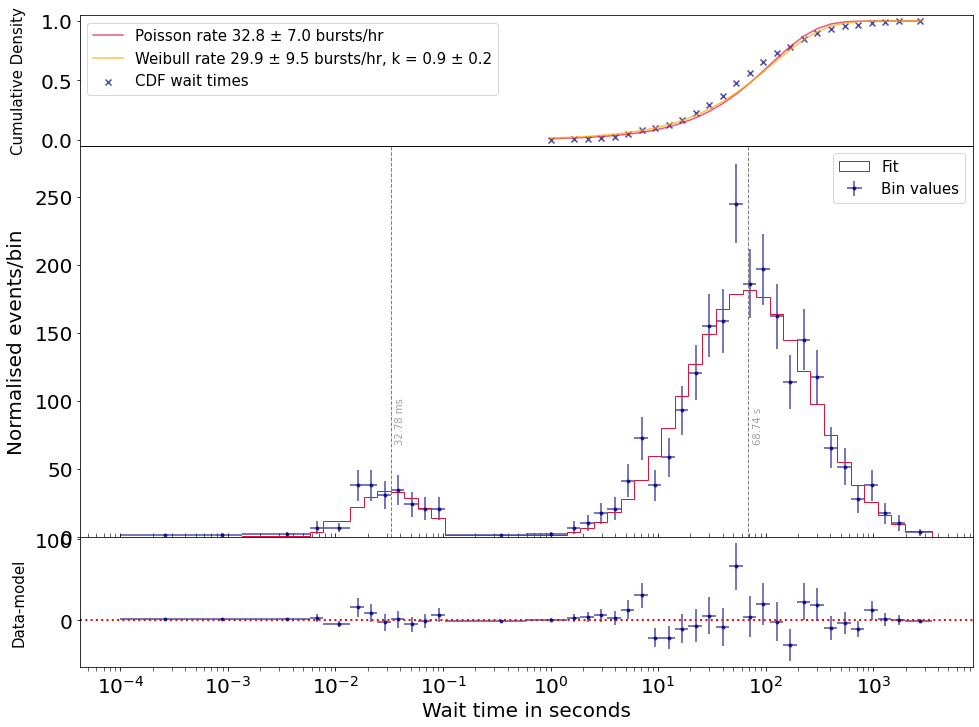

In [24]:
_ = fit_gaussian_to_dataset(np.array(wait_time), 60, plot=True)

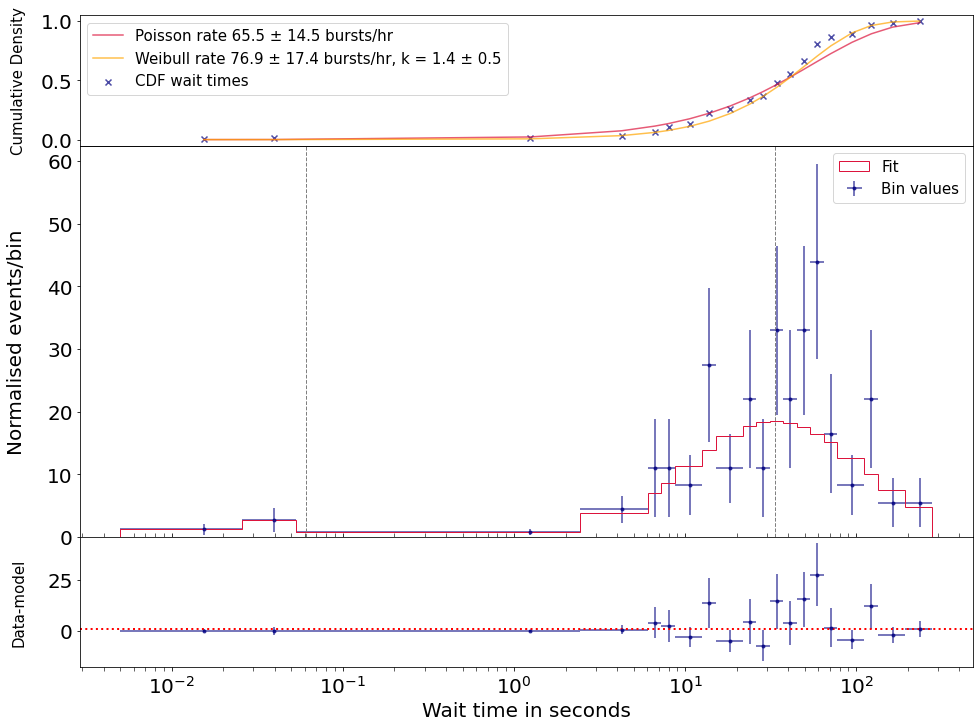

In [25]:
_ = fit_gaussian_to_dataset(np.array(wait_time_59877), 60, plot=True)

## Burst Rate

In [26]:
with open('Observation times.txt') as f:
    lines = f.readlines()

obs_dict = {}
for i in range(len(lines)):
    if lines[i].split('pc')[0].split(' ')[-1] == '219.5':
        mjd = lines[i].split('_')[1]
        obs_sec = float(lines[i].split(' ')[2])
        
        if mjd in np.unique(cand_ar):
            index_sorted_mjdlist = np.argwhere(np.unique(cand_ar) == mjd)[0][0]
            burst_rate = len(cand_ordered_full_ar[index_sorted_mjdlist])
            obs_dict[mjd] = [obs_sec, burst_rate]
        else: 
            obs_dict[mjd] = [obs_sec, 0]

In [27]:
burst_rate_dict = {}

for i in range(len(obs_dict.keys())):
    rate = np.array([np.array(list(obs_dict.values()))[:,1][i]])
    obs_dur_hour = np.array(list(obs_dict.values()))[:,0][i]/(60*60)
    lower_lim, upper_lim = get_poisson_error(rate)
    burst_rate_dict[list(obs_dict.keys())[i]] = [rate[0]/obs_dur_hour, lower_lim[0]/obs_dur_hour, upper_lim[0]/obs_dur_hour]

In [28]:
mjd_array = np.array(sorted(burst_rate_dict.keys()), dtype=int)
obs_duration = np.flip(np.array(list(obs_dict.values()))[:,0])
rate_array = np.flip(np.array(list(burst_rate_dict.values()))[:,0])
rate_lower = np.flip(np.array(list(burst_rate_dict.values()))[:,1])
rate_upper = np.flip(np.array(list(burst_rate_dict.values()))[:,2])

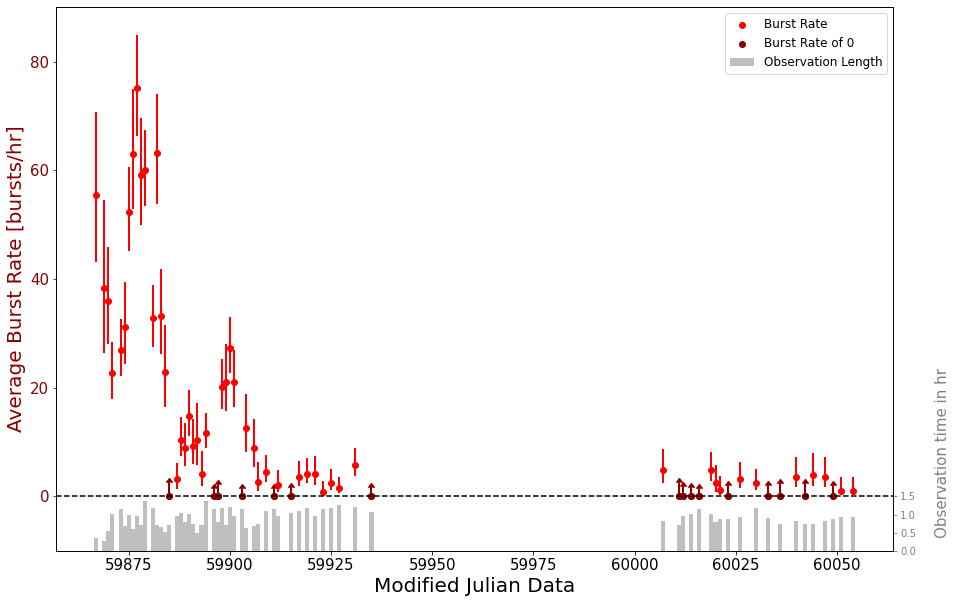

In [29]:
fig ,ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax2.bar(mjd_array, obs_duration/3600, width = 1, alpha = 0.5, color = 'gray', zorder=0, label='Observation Length')
ax2.scatter(60000, 100, color='r', label= 'Burst Rate', marker = 'o')
ax2.scatter(60000, 100, color='darkred', label= 'Burst Rate of 0', marker = 'o')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylabel('Observation time in hr', fontsize = 15)
ax1.errorbar(mjd_array, rate_array, [rate_array-rate_lower, rate_upper-rate_array], lolims = rate_array == 0, zorder = 1, linewidth = 2, label='Count', fmt='o', color='r')

ax1.errorbar(mjd_array[np.argwhere(rate_array==0)], rate_array[np.argwhere(rate_array==0)], [np.array(rate_array-rate_lower)[np.argwhere(rate_array==0)].T[0], np.array(rate_upper-rate_array)[np.argwhere(rate_array==0)].T[0]], lolims = True, zorder = 1, linewidth = 2, label='Count', fmt='o', color='darkred')
# [np.argwhere(rate_array==0)]
ax1.set_xlabel('Modified Julian Data', fontsize = 20)
ax1.set_ylabel('Average Burst Rate [bursts/hr]', fontsize = 20)
ax1.axhline(y = 0, linestyle='--', color='k')
ax1.set_ylim(-10, 90)
ax2.set_ylim(0,15)
ax2.set_yticks([0,0.5,1,1.5])
ax2.yaxis.set_label_coords(1.05,0.18)
ax2.yaxis.label.set_color('gray')
ax1.yaxis.label.set_color('darkred')
ax1.tick_params(axis='y', colors='darkred') 
ax2.tick_params(axis='y', colors='gray') 
plt.legend(prop = {"size": 12})
plt.savefig('AverageBurstRate.pdf')
plt.show()

### Burst Rate vs Energy

In [30]:
frb_fluence = []
bandwidth = []

for i in range(len(burst_csv[burst_csv['Real Burst'] == True])):
    frb_fluence.append(float(np.array(burst_csv[burst_csv['Real Burst'] == True]['fluence'])[i]))
    bandwidth.append(4*float(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])[i]))

In [31]:
fluence_Jys = (np.array(frb_fluence)*1e-3)
distance =  362.4

distance_lum_cm = 3.086e24*distance
energy_spec= fluence_Jys*4*np.pi*(distance_lum_cm**2)*1e-23
energy_iso = energy_spec * np.array(bandwidth)*1e6 

In [32]:
np.unique(np.array(frb_time, dtype=int))

median_energies_per_obs = [[] for _ in range(len(np.unique(np.array(frb_time, dtype=int))))]
frb_median_list = []

for i in range(len(frb_time)):
    for j in range(len(np.unique(np.array(frb_time, dtype=int)))):
        if np.unique(np.array(frb_time, dtype=int))[j] == np.array(frb_time, dtype=int)[i]:
            median_energies_per_obs[j].append(energy_iso[i])
    
for i in range(len(median_energies_per_obs)):
    median_energies_per_obs[i] = np.median(median_energies_per_obs[i])
    
for i in range(len(cand_ordered_full_ar)):
    frb_median_list.append(np.average(np.array(cand_ordered_full_ar[i], dtype=float)))

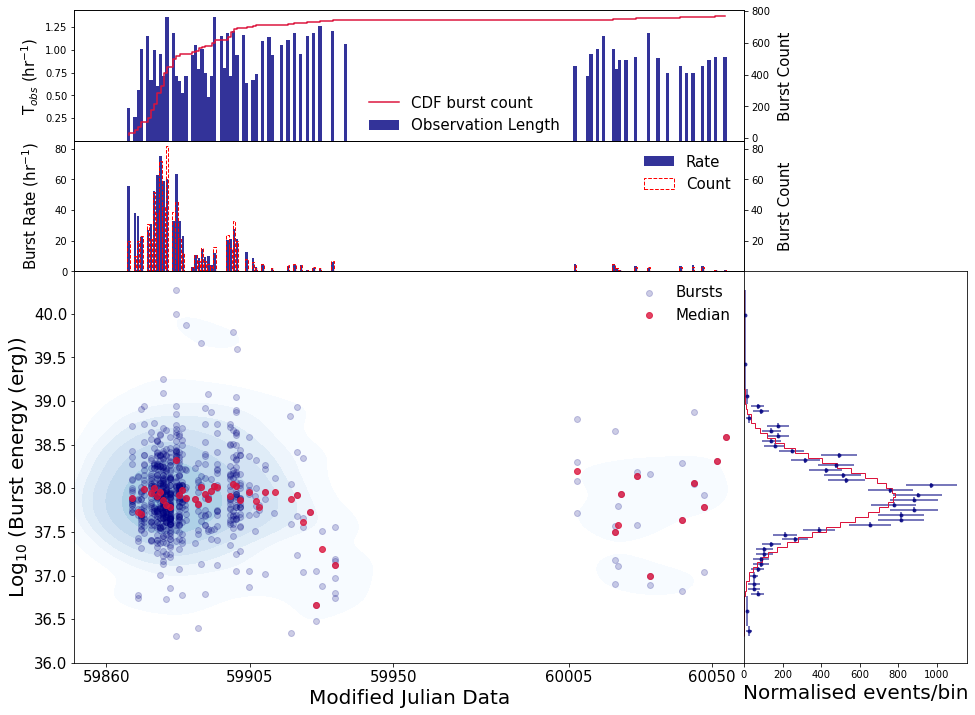

In [33]:
x = np.log10(abs(energy_iso))
y = frb_time
xmin, xmax = 36, 40
ymin, ymax = 59850, 60100

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

nbins = 70
counts, edges = np.histogram(np.log10(abs(energy_iso)), bins=nbins, density=False)
#rebin the data into different bins and counts
mincounts = 3
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

bwidths = np.diff(edges2)

p0 = [38, 0.2, 401]
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, normal, *parm), energies, cdens, p0, sigma=cdens_err)
best_model = model_int_cf(energies, edges2, normal, *ml_cfpars)

CDF_burst = []
counter = 0
for i in range(len(cand_ordered_full_ar)):
    counter += len(cand_ordered_full_ar[i])
    CDF_burst.append(counter)

fig = plt.figure(figsize=(16, 12))
rows=3
cols=2
widths = [3,1]
heights = [1,1,3]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

ax1 = fig.add_subplot(gs[2,0])
cfset = ax1.contourf(yy, xx, f, np.logspace(-3.5, -1, 10), norm=colors.LogNorm(vmin=1e-3, vmax=1e1), cmap='Blues')
ax1.scatter(frb_time, np.log10(abs(energy_iso)), alpha = 0.2, color ='navy', label='Bursts')
ax1.scatter(frb_median_list, np.log10(abs(np.array(median_energies_per_obs))), alpha = 0.8, color ='crimson', label='Median')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Modified Julian Data', fontsize = 20)
ax1.set_ylabel(r'Log$_{10}$ (Burst energy (erg))', fontsize = 20)
ax1.set_xlim(ymin, ymax)
# ax1.axhline(y= np.percentile(np.log10(abs(energy_iso)),10), alpha = 0.6, linestyle='--', color='k', label='10% detection threshold')
ax1.set_xticks([59860, 59905, 59950, 60005, 60050])
leg = ax1.legend(prop={'size':15})
leg.get_frame().set_edgecolor('w')
ax1.set_xlim(59850, 60060)

ax2 = fig.add_subplot(gs[2,1], sharey=ax1)
model_hist, edges, patches = ax2.hist(energies, bins=edges2, weights = best_model, color = 'crimson', orientation=u'horizontal', density= False, histtype='step', label='Fit')
ax2.errorbar(cdens, energies, yerr=bwidths/2, xerr=cdens_err, fmt='.', label='Bin values', color = 'navy', alpha = 0.7)
ax2.set_xlabel('Normalised events/bin', fontsize = 20)
ax2.set_ylabel(r'Log$_{10}$ (Burst energy (erg))', fontsize = 20)
# ax2.axhline(y= np.percentile(np.log10(abs(energy_iso)),10), alpha = 0.6, linestyle='--', color='k', label='10% detection threshold')
ax2.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3.bar(mjd_array, rate_array, zorder = 1, linewidth = 2, label='Rate', alpha = 0.8, color='navy')
ax3.bar(mjd_array, rate_array*(obs_duration/3600), facecolor='None', zorder = 1, linewidth = 1, label='Count', edgecolor='r', linestyle='--')
ax3.set_ylabel(r'Burst Rate (hr$^{-1}$)', fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.set_ylim(0,85)
ax3.get_xaxis().set_visible(False)
ax3.yaxis.set_label_coords(-0.05,0.5)
leg = ax3.legend(prop={'size':15})
leg.get_frame().set_edgecolor('w')
ax4 = ax3.twinx()
ax4.set_ylabel(r'Burst Count', fontsize = 15)
ax4.set_yticks([20, 40, 60, 80])
ax4.set_ylim([0, 85])
ax4.yaxis.set_label_coords(1.05,0.5)

ax5 = fig.add_subplot(gs[0,0], sharex=ax1)
ax5.bar(mjd_array, obs_duration/3600, width = 1, alpha = 0.8, color = 'navy', zorder=0, label='Observation Length')
ax5.plot(59910,0, drawstyle='steps', c='crimson', label='CDF burst count')
ax5.set_ylabel(r'T$_{obs}$ (hr$^{-1}$)', fontsize = 15)
ax5.tick_params(axis='both', which='major', labelsize=10)
ax5.get_xaxis().set_visible(False)
ax5.set_yticks([0.25, 0.5, 0.75, 1.00, 1.25])
ax5.yaxis.set_label_coords(-0.05,0.5)
leg = ax5.legend(prop={'size':15}, bbox_to_anchor=(0.42,0.45))
leg.get_frame().set_edgecolor('w')
ax6 = ax5.twinx()
ax6.set_ylabel(r'Burst Count', fontsize = 15)
ax6.plot(np.unique(np.array(frb_time, dtype=int)), CDF_burst, drawstyle='steps', c='crimson')
ax6.yaxis.set_label_coords(1.05,0.5)
plt.savefig('full_burst_energy.pdf')
plt.show()

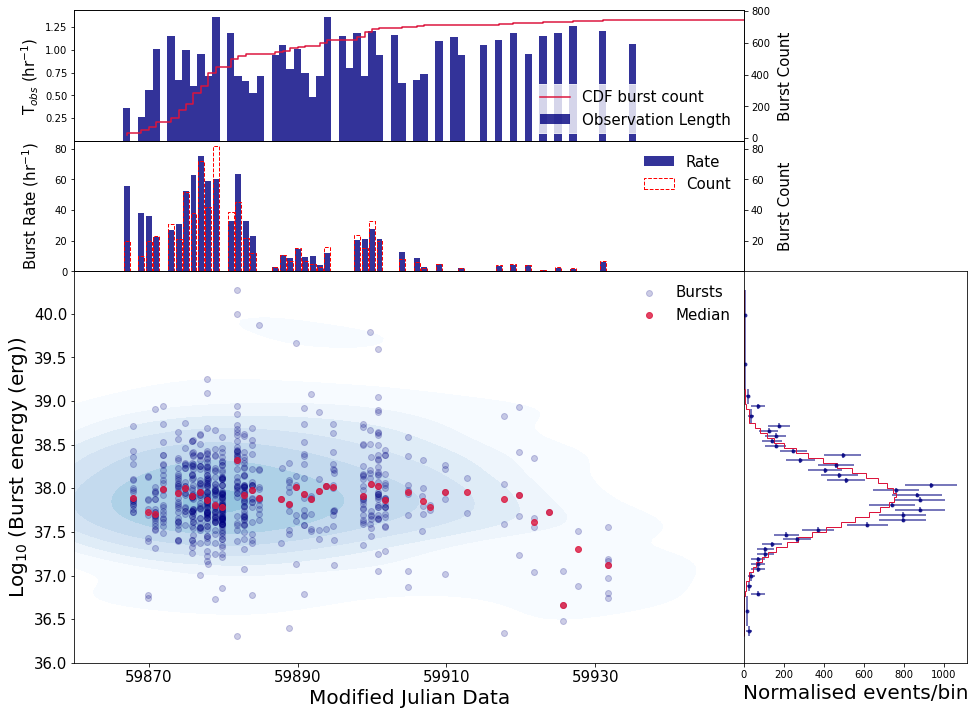

In [34]:
x = np.log10(abs(energy_iso))
y = frb_time
xmin, xmax = 36, 40
ymin, ymax = 59850, 60100

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

nbins = 70
counts, edges = np.histogram(np.log10(abs(energy_iso[29:])), bins=nbins, density=False)
#rebin the data into different bins and counts
mincounts = 3
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

bwidths = np.diff(edges2)

p0 = [38, 0.2, 401]
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, normal, *parm), energies, cdens, p0, sigma=cdens_err)
best_model = model_int_cf(energies, edges2, normal, *ml_cfpars)

CDF_burst = []
counter = 0
for i in range(len(cand_ordered_full_ar)):
    counter += len(cand_ordered_full_ar[i])
    CDF_burst.append(counter)

fig = plt.figure(figsize=(16, 12))
rows=3
cols=2
widths = [3,1]
heights = [1,1,3]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

ax1 = fig.add_subplot(gs[2,0])
cfset = ax1.contourf(yy, xx, f, np.logspace(-3.5, -1, 10), norm=colors.LogNorm(vmin=1e-3, vmax=1e1), cmap='Blues')
ax1.scatter(frb_time, np.log10(abs(energy_iso)), alpha = 0.2, color ='navy', label='Bursts')
ax1.scatter(frb_median_list, np.log10(abs(np.array(median_energies_per_obs))), alpha = 0.8, color ='crimson', label='Median')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Modified Julian Data', fontsize = 20)
ax1.set_ylabel(r'Log$_{10}$ (Burst energy (erg))', fontsize = 20)
ax1.set_xlim(ymin, ymax)
ax1.set_xticks([59870, 59890, 59910, 59930])
leg = ax1.legend(prop={'size':15})
leg.get_frame().set_edgecolor('w')
ax1.set_xlim(59860, 59950)

ax2 = fig.add_subplot(gs[2,1], sharey=ax1)
model_hist, edges, patches = ax2.hist(energies, bins=edges2, weights = best_model, color = 'crimson', orientation=u'horizontal', density= False, histtype='step', label='Fit')
ax2.errorbar(cdens, energies, yerr=bwidths/2, xerr=cdens_err, fmt='.', label='Bin values', color = 'navy', alpha = 0.7)
ax2.set_xlabel('Normalised events/bin', fontsize = 20)
ax2.set_ylabel(r'Log$_{10}$ (Burst energy (erg))', fontsize = 20)
ax2.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3.bar(mjd_array, rate_array, zorder = 1, linewidth = 2, label='Rate', alpha = 0.8, color='navy')
ax3.bar(mjd_array, rate_array*(obs_duration/3600), facecolor='None', zorder = 1, linewidth = 1, label='Count', edgecolor='r', linestyle='--')
ax3.set_ylabel(r'Burst Rate (hr$^{-1}$)', fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.set_ylim(0,85)
ax3.get_xaxis().set_visible(False)
ax3.yaxis.set_label_coords(-0.05,0.5)
leg = ax3.legend(prop={'size':15})
leg.get_frame().set_edgecolor('w')
ax4 = ax3.twinx()
ax4.set_ylabel(r'Burst Count', fontsize = 15)
ax4.set_yticks([20, 40, 60, 80])
ax4.set_ylim([0, 85])
ax4.yaxis.set_label_coords(1.05,0.5)

ax5 = fig.add_subplot(gs[0,0], sharex=ax1)
ax5.bar(mjd_array, obs_duration/3600, width = 1, alpha = 0.8, color = 'navy', zorder=0, label='Observation Length')
ax5.plot(59910,0, drawstyle='steps', c='crimson', label='CDF burst count')
ax5.set_ylabel(r'T$_{obs}$ (hr$^{-1}$)', fontsize = 15)
ax5.tick_params(axis='both', which='major', labelsize=10)
ax5.get_xaxis().set_visible(False)
ax5.set_yticks([0.25, 0.5, 0.75, 1.00, 1.25])
ax5.yaxis.set_label_coords(-0.05,0.5)
leg = ax5.legend(prop={'size':15}, loc='lower right')
leg.get_frame().set_edgecolor('w')
ax6 = ax5.twinx()
ax6.set_ylabel(r'Burst Count', fontsize = 15)
ax6.plot(np.unique(np.array(frb_time, dtype=int)), CDF_burst, drawstyle='steps', c='crimson')
ax6.yaxis.set_label_coords(1.05,0.5)
plt.savefig('early_burstenergy.pdf')
plt.show()

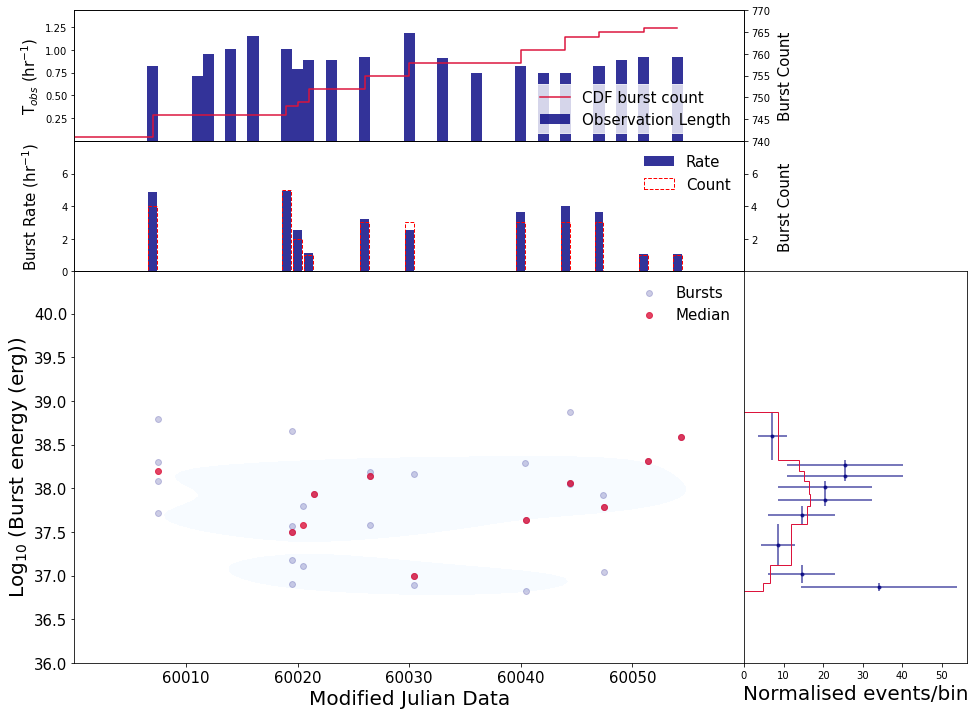

In [35]:
x = np.log10(abs(energy_iso))
y = frb_time
xmin, xmax = 36, 40
ymin, ymax = 59850, 60100

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

nbins = 70
counts, edges = np.histogram(np.log10(abs(energy_iso[:29])), bins=nbins, density=False)
#rebin the data into different bins and counts
mincounts = 3
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

bwidths = np.diff(edges2)

p0 = [38, 0.2, 401]
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, normal, *parm), energies, cdens, p0, sigma=cdens_err)
best_model = model_int_cf(energies, edges2, normal, *ml_cfpars)

CDF_burst = []
counter = 0
for i in range(len(cand_ordered_full_ar)):
    counter += len(cand_ordered_full_ar[i])
    CDF_burst.append(counter)

fig = plt.figure(figsize=(16, 12))
rows=3
cols=2
widths = [3,1]
heights = [1,1,3]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

ax1 = fig.add_subplot(gs[2,0])
cfset = ax1.contourf(yy, xx, f, np.logspace(-3.5, -1, 10), norm=colors.LogNorm(vmin=1e-3, vmax=1e1), cmap='Blues')
ax1.scatter(frb_time, np.log10(abs(energy_iso)), alpha = 0.2, color ='navy', label='Bursts')
ax1.scatter(frb_median_list, np.log10(abs(np.array(median_energies_per_obs))), alpha = 0.8, color ='crimson', label='Median')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Modified Julian Data', fontsize = 20)
ax1.set_ylabel(r'Log$_{10}$ (Burst energy (erg))', fontsize = 20)
ax1.set_xlim(ymin, ymax)
ax1.set_xticks([60010, 60020, 60030, 60040, 60050])
leg = ax1.legend(prop={'size':15})
leg.get_frame().set_edgecolor('w')
ax1.set_xlim(60000, 60060)

ax2 = fig.add_subplot(gs[2,1],sharey=ax1)

model_hist, edges, patches = ax2.hist(energies, bins=edges2, weights = best_model, color = 'crimson', orientation=u'horizontal', density= False, histtype='step', label='Fit')
ax2.errorbar(cdens, energies, yerr=bwidths/2, xerr=cdens_err, fmt='.', label='Bin values', color = 'navy', alpha = 0.7)
ax2.set_xlabel('Normalised events/bin', fontsize = 20)
ax2.set_ylabel(r'Log$_{10}$ (Burst energy (erg))', fontsize = 20)
ax2.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3.bar(mjd_array, rate_array, zorder = 1, linewidth = 2, label='Rate', alpha = 0.8, color='navy')
ax3.bar(mjd_array, rate_array*(obs_duration/3600), facecolor='None', zorder = 1, linewidth = 1, label='Count', edgecolor='r', linestyle='--')
ax3.set_ylabel(r'Burst Rate (hr$^{-1}$)', fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.set_ylim(0,8)
ax3.set_yticks([0, 2, 4, 6])
ax3.get_xaxis().set_visible(False)
ax3.yaxis.set_label_coords(-0.05,0.5)
leg = ax3.legend(prop={'size':15})
leg.get_frame().set_edgecolor('w')
ax4 = ax3.twinx()
ax4.set_ylabel(r'Burst Count', fontsize = 15)
ax4.set_yticks([2, 4, 6])
ax4.set_ylim([0, 8])
ax4.yaxis.set_label_coords(1.05,0.5)

ax5 = fig.add_subplot(gs[0,0], sharex=ax1)
ax5.bar(mjd_array, obs_duration/3600, width = 1, alpha = 0.8, color = 'navy', zorder=0, label='Observation Length')
ax5.plot(59910,0, drawstyle='steps', c='crimson', label='CDF burst count')
ax5.set_ylabel(r'T$_{obs}$ (hr$^{-1}$)', fontsize = 15)
ax5.tick_params(axis='both', which='major', labelsize=10)
ax5.get_xaxis().set_visible(False)
ax5.set_yticks([0.25, 0.5, 0.75, 1.00, 1.25])
ax5.yaxis.set_label_coords(-0.05,0.5)
leg = ax5.legend(prop={'size':15}, loc='lower right')
leg.get_frame().set_edgecolor('w')
ax6 = ax5.twinx()
ax6.set_ylabel(r'Burst Count', fontsize = 15)
ax6.plot(np.unique(np.array(frb_time, dtype=int)), CDF_burst, drawstyle='steps', c='crimson')
ax6.yaxis.set_label_coords(1.05,0.5)
ax6.set_ylim(740,770)
plt.savefig('late_burstenergy.pdf')
plt.show()

### CDF Rate vs Energy

In [36]:
sorted_energy = np.flip(np.sort(energy_iso))
cum_rate = np.array(range(1,len(sorted_energy)+1))/sum(obs_duration/3600)



In [37]:
def model_int_cf(ecent, ebins, model, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.
       Inputs:
           ecent - energy bin centres, dummy array with length len(ebins)-1 to fool curve_fit into 
                   accepting the function as the correct format for curve_fit.
           ebins - energy bin edges.
           model, parm - the curve_fit model name and input parameter list.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
#         print(ebins[i+1]-ebins[i])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

TypeError: _around_dispatcher() missing 1 required positional argument: 'a'

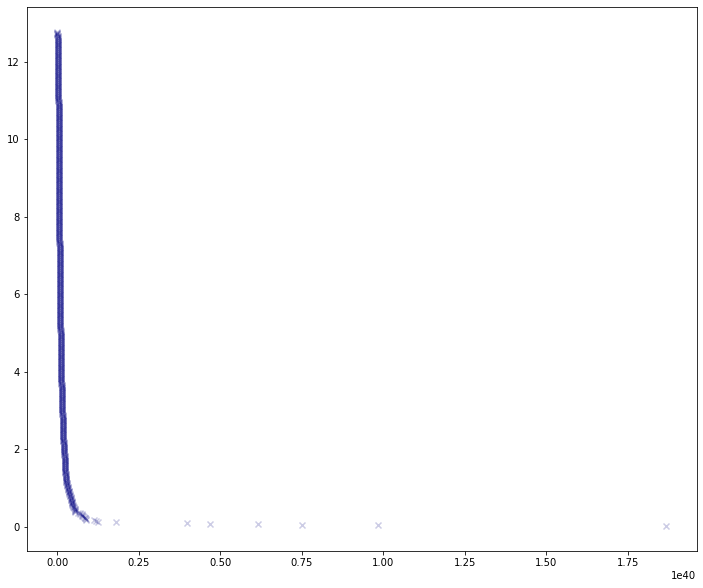

In [38]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the power-law function
def power_law(x, a, b):
    return a * x**b

x = sorted_energy[5:400]/1e36
y = cum_rate[5:400]

# Fit the power-law function to the data
params, _ = curve_fit(power_law, x, y)

# Extract the fitted parameters
a_fit, b_fit = params

# Generate points along the fitted curve
x_fit = np.linspace(1,1e5, 100)
y_fit = power_law(x_fit, a_fit, b_fit)

fig = plt.figure(figsize=(12, 10))
plt.scatter(sorted_energy, cum_rate, alpha = 0.2, color ='navy', marker='x')
plt.plot(x_fit*1e36, y_fit, linestyle='--', c='k', label = r'\alpha = '+str(np.round()))
plt.xlabel('Burst Energy (erg)', fontsize = 20)
plt.ylabel(r'Burst rate > Burst Energy[hr$^{-1}$]', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.01, 20)
plt.xlim(1e36, 4e40)
plt.savefig('CDF_burstrate-vs-fluence.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 10))
plt.scatter(sorted_energy, cum_rate, alpha = 0.2, color ='navy', marker='x')
plt.xlabel('Burst Energy (erg)', fontsize = 20)
plt.ylabel(r'Burst rate > Burst Energy[hr$^{-1}$]', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.savefig('CDF_burstrate-vs-fluence.pdf')
plt.show()